In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40121")
client

<Client: 'tcp://127.0.0.1:40121' processes=12 threads=60, memory=254.00 GB>

In [3]:
import numpy as np
import xarray as xr
import gsw
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import scipy.sparse as spar
import dask.array as dsar
import xrft
import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [4]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [5]:
year = 1964
dnf = 2160
itime = 1002240+dnf

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50
nremap = 80

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [6]:
# for nmemb in range(24,36):
#     if nmemb == 24:
#         ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                      % (nmemb,year)), 
#                              grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
#                              iters=943920,
#                              prefix=['diag_ocnSnap'], delta_t=2e2,
#                             ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                  ).chunk({'XC':xchunk,'XG':xchunk,
#                                           'YC':ychunk,'YG':ychunk})
#     else:
#         ds = xr.concat([ds, open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                                     % (nmemb,year)), 
#                                             grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
#                                             iters=943920,
#                                             prefix=['diag_ocnSnap'], delta_t=2e2,
#                                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                                 ).chunk({'XC':xchunk,'XG':xchunk,
#                                                          'YC':ychunk,'YG':ychunk})],
#                        dim='nmemb')
# ds = ds.isel(time=slice(-len(dsmn.time),None))
# pot_rho = xr.apply_ufunc(jmd95.densjmd95, ds.SALT.mean('nmemb'), ds.THETA.mean('nmemb'),
#                          0., # pressure in [dbar]!!!!
#                          dask='parallelized', output_dtypes=[float,]
#                         ).where(ds.maskC!=0.)
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (24,year)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=itime,
                     prefix=['diag_ocnSnap'], delta_t=2e2,
                    ).sel(YC=slice(yNstart-12**-1,yend+2*12**-1),
                          YG=slice(yNstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 483, YG: 483, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float64 2.009e+08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 9.916701 10.000034 10.083367 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG       (YG) >f4 9.958367 10.041701 10.125034 ... 50.041702 50.125034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1      (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu       (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl       (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxG      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAz      (YG, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    drC      (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefF   (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    PHIHYD   (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [7]:
dsmn = xr.open_dataset(op.join(ddir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
                               % (year,nremap,itime))
                      ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
                               'XC':xchunk,'XG':xchunk,
                               'YC':ychunk,'YG':ychunk})
dsz = xr.open_dataset(op.join(ddir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
                              % (year,nremap,itime))
                     ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
                              'XC':xchunk,'XG':xchunk,
                              'YC':ychunk,'YG':ychunk})
dsep = xr.open_dataset(op.join(ddir,'%4d/E-P_flux_parallel-%2d_%010d.nc' 
                               % (year,nremap,itime))
                      ).chunk({'sig':schunk,'sigp1':schunk,
                               'XC':xchunk,'XG':xchunk,
                               'YC':ychunk,'YG':ychunk})
dsdiv = xr.open_dataset(op.join(ddir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
                                % (year,nremap,itime))
                       ).chunk({'sig':schunk,'sigp1':schunk,
                                'XC':xchunk,'XG':xchunk,
                                'YC':ychunk,'YG':ychunk})
dspi = xr.open_dataset(op.join(ddir,'%4d/Varpidz-compressible_membs_parallel-%2d_%010d.nc' 
                               % (year,nremap,itime))
                      ).chunk({'sig':schunk,'sigp1':schunk,
                               'XC':xchunk,'YC':ychunk})
# dsmn.coords['time'] = ('time',dsraw.time.data[:len(dsmn.time)])
# dsmn.coords['time'] = ('time',ds.time.data)
# dsz.coords['time'] = ('time',ds.time.data)
grid = Grid(dsz, periodic=['X'], 
            coords={'Z':{'center':'sig','outer':'sigp1'},
                   'Y':{'center':'YC','left':'YG'},
                   'X':{'center':'XC','left':'XG'}}
           )

dsmn

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 483, YG: 483, nmemb: 12, sig: 60, sigp1: 61)
Coordinates:
    maskInS  (YG, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    time     timedelta64[ns] ...
    dyC      (YG, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    iter     int64 ...
    dxG      (YG, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
  * YG       (YG) float32 9.958367 10.041701 10.125034 ... 50.041702 50.125034
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    dxC      (YC, XG) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyG      (YC, XG) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
  * YC       (YC) float32 9.916701 10.000034 10.083367 ... 50.000034 50.08337
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
  * sigp1    (sigp1) float64 19.75 20.25 20.76 21.27 ... 48.73 49.24 49.75 50.25
Data variables:
    vdz      (nmemb, YG, XC, sig) float32 dask.array<chunksize=(1, 400, 250, 60), meta=np.ndarray>
    udz      (nmemb, YC, XG, sig) float32 dask.array<chunksize=(1, 400, 250, 60), meta=np.ndarray>
    tdz      (nmemb, YC, XC, sig) float32 dask.array<chunksize=(1, 400, 250, 60), meta=np.ndarray>
    sdz      (nmemb, YC, XC, sig) float32 dask.array<chunksize=(1, 400, 250, 60), meta=np.ndarray>
    pxdz     (nmemb, YC, XG, sig) float32 dask.array<chunksize=(1, 400, 250, 60), meta=np.ndarray>
    pydz     (nmemb, YG, XC, sig) float32 dask.array<chunksize=(1, 400, 250, 60), meta=np.ndarray>

In [8]:
mld = xr.open_dataset(op.join(ddir,'%4d/MLD_%4d.nc' % (year,year)),
                      chunks={'time':1,'XC':xchunk,'YC':ychunk}).MLD
mld

<xarray.DataArray 'MLD' (time: 73, YC: 783, XC: 1000)>
dask.array<open_dataset-7d6174171cd95c028edcbc8daf1fb367MLD, shape=(73, 783, 1000), dtype=float64, chunksize=(1, 400, 250), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
    hFacC    (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskC    (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    drF      float32 ...
    Depth    (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    PHrefC   float32 ...
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 2190 days 2195 days ... 2545 days 2550 days
    Z        float32 ...
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725

In [9]:
fC = xr.apply_ufunc(gsw.f, dsz.YC)
fG = xr.apply_ufunc(gsw.f, dsz.YG)
buoyb = -grav * dsmn.sig * rhoConst**-1
buoybp1 = -grav * dsmn.sigp1 * rhoConst**-1
sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

zetab = (dsz.zdz*dsz.dzetaF**-1).mean('nmemb',skipna=True)
zetaxb = (dsz.zxdz*dsz.dzetaFx**-1).mean('nmemb',skipna=True)
zetayb = (dsz.zydz*dsz.dzetaFy**-1).mean('nmemb',skipna=True)
# sigmab = grid.interp(grid.diff(zetab,'Z',boundary='fill') 
#                      * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                      'Z',boundary='fill')
# sigmazb = (grid.diff(zetab,'Z',boundary='fill') 
#            * grid.diff(buoyb,'Z',boundary='fill')**-1)
# sigmayb = grid.interp(grid.diff(zetayb,'Z',boundary='fill') 
#                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                       'Z',boundary='fill')
# sigmaxb = grid.interp(grid.diff(zetaxb,'Z',boundary='fill') 
#                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                       'Z',boundary='fill')
sigmab = (dsz.dzetaF.mean('nmemb',skipna=True) 
          * -grid.diff(buoybp1,'Z',boundary='fill')**-1
         )
sigmaxb = (dsz.dzetaFx.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmayb = (dsz.dzetaFy.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmazb = (dsz.dzetaFz.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
    
# vhat = ((dsmn.vdz * -grid.diff(buoybp1,'Z',boundary='fill'
#                               )**-1 # vdz * db**-1 = v * dz/db = v * \sigma
#         ).mean('nmemb',skipna=True)
#         * sigmayb**-1
#        )
# uhat = ((dsmn.udz * -grid.diff(buoybp1,'Z',boundary='fill')**-1
#         ).mean('nmemb',skipna=True)
#         * sigmaxb**-1
#        )
vhat = dsmn.vdz.mean('nmemb',skipna=True) * dsz.dzetaFy.mean('nmemb',skipna=True)**-1
uhat = dsmn.udz.mean('nmemb',skipna=True) * dsz.dzetaFx.mean('nmemb',skipna=True)**-1
KE = .5*(grid.interp(uhat**2,'X') 
         + grid.interp(vhat**2,'Y',boundary='fill')
        )
Ro = (grid.diff(vhat*ds.dyC,'X') 
      - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
     ) * ds.rAz**-1 * fG**-1
KE

<xarray.DataArray (YC: 483, XC: 1000, sig: 60)>
dask.array<mul, shape=(483, 1000, 60), dtype=float32, chunksize=(399, 249, 60), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 9.916701 10.000034 10.083367 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

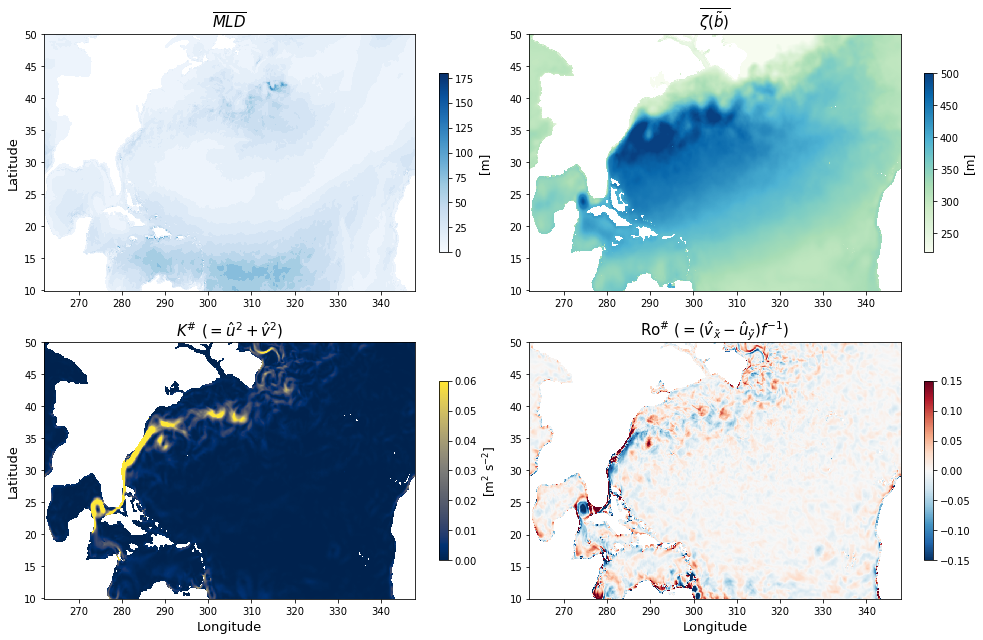

In [11]:
fig, axes = plt.subplots(figsize=(14,9), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(mld.XC, mld.YC.sel(YC=slice(yNstart-12**-1,yend+12**-1)),
                           -mld.sel(YC=slice(yNstart-12**-1,
                                             yend+12**-1)).isel(time=int((itime-946080)/dnf)), 
                           vmin=0, vmax=180, cmap='Blues', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart-5-12**-1,yend+12**-1)), 
                           -(dsz.zdz*dsz.dzetaF**-1).sel(YC=slice(yNstart-5-12**-1,yend+12**-1)
                                                        ).isel(sig=16).mean('nmemb'),
                           vmin=2.2e2, vmax=5e2, cmap='GnBu', rasterized=True)
im2 = axes[1,0].pcolormesh(KE.XC, KE.YC.sel(YC=slice(yNstart-5-12**-1,yend+12**-1)), 
                           KE.sel(YC=slice(yNstart-5-12**-1,yend+12**-1)).isel(sig=16), 
                           vmin=0, vmax=.06, cmap='cividis', rasterized=True)
im3 = axes[1,1].pcolormesh(uhat.XG, vhat.YG.sel(YG=slice(yNstart-5-12**-1,yend+12**-1)), 
                           Ro.sel(YG=slice(yNstart-5-12**-1,yend+12**-1)).isel(sig=16),
                           vmin=-.15e0, vmax=.15e0, cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$\overline{MLD}$", fontsize=15)
axes[0,1].set_title(r"$\overline{\zeta(\tilde{b})}$", fontsize=15)
axes[1,0].set_title(r"$K^\#\ (=\hat{u}^2 + \hat{v}^2)$", fontsize=15)
axes[1,1].set_title(r"Ro$^\#\ (=(\hat{v}_\tilde{x}-\hat{u}_\tilde{y}) f^{-1})$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
# cbar3.set_label(r"[s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/mean_%4d-%010d.pdf' % (year,itime)))

In [10]:
vort = (grid.diff(vhat*ds.dyC,'X') 
        - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
       ) * ds.rAz**-1
Pi = ((grid.interp(grid.interp(vort,'X'),'Y',boundary='fill') 
       + fC) * sigmab**-1)
Pi_f = (1. + grid.interp(grid.interp(vort,'X'),
                         'Y',boundary='fill') * fC**-1
       ) * sigmab**-1
Pi_f

<xarray.DataArray (YC: 483, XC: 1000, sig: 60)>
dask.array<mul, shape=(483, 1000, 60), dtype=float64, chunksize=(398, 248, 60), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 9.917 10.0 10.08 10.17 ... 49.83 49.92 50.0 50.08
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    time     timedelta64[ns] 2325 days
    iter     int64 1004400
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(400, 250), meta=np.ndarray>

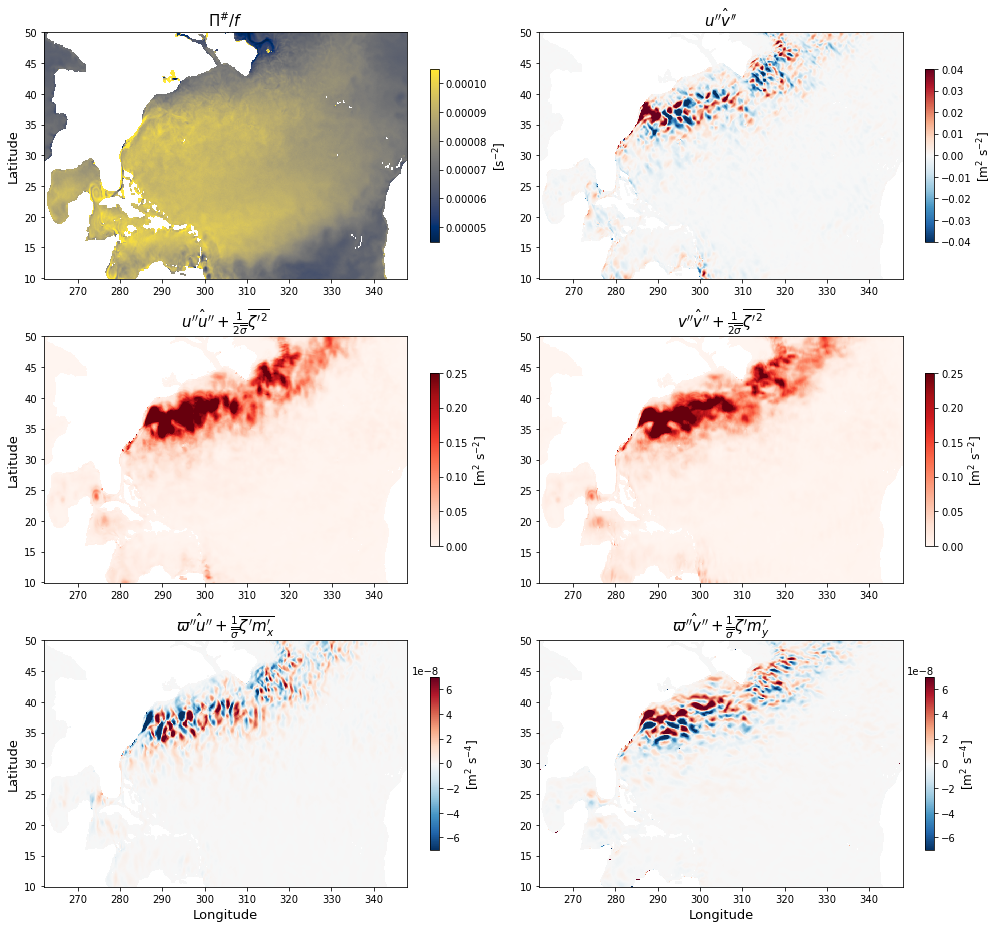

In [13]:
fig, axes = plt.subplots(figsize=(14,13), nrows=3, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC, Pi_f.isel(sig=16), 
                           vmin=.45e-4, vmax=1.05e-4, cmap='cividis', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XG, dsz.YC, e01.isel(sig=16), 
                           vmax=4e-2, vmin=-4e-2, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XG, dsz.YC, e00.isel(sig=16), 
                           vmax=2.5e-1, vmin=0, cmap='Reds', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YG, e11.isel(sig=16), 
                           vmax=2.5e-1, vmin=0, cmap='Reds', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC, e20.isel(sig=16), 
                           vmax=7e-8, vmin=-7e-8, cmap='RdBu_r', rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC, e21.isel(sig=16), 
                           vmax=7e-8, vmin=-7e-8, cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$\Pi^\#/f$", fontsize=15)
axes[1,0].set_title(r"$\hat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", 
                    fontsize=15)
axes[0,1].set_title(r"$\hat{u''v''}$", fontsize=15)
axes[1,1].set_title(r"$\hat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", 
                    fontsize=15)
axes[2,0].set_title(r"$\hat{\varpi''u''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_x'}$", 
                    fontsize=15)
axes[2,1].set_title(r"$\hat{\varpi''v''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'}$", 
                    fontsize=15)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[s$^{-2}$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
cbar4.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)
cbar5 = fig.colorbar(im5, ax=axes[2,1], shrink=.7)
cbar5.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/E-P_flux_%4d-%010d.pdf' % (year,itime)))

In [11]:
# varpihat = ((dsmn.varpi * sigma).mean('nmemb',skipna=True) 
#             * sigmab**-1)
varpihat = (dspi.varpidz.mean('nmemb',skipna=True) 
            * dsz.dzetaF.mean('nmemb',skipna=True)**-1)

vpp = dsmn.vdz*dsz.dzetaFy**-1 - vhat
upp = dsmn.udz*dsz.dzetaFx**-1 - uhat
varpipp = dspi.varpidz*dsz.dzetaF**-1 - varpihat

zetap = (dsz.zdz*dsz.dzetaF**-1 - zetab) 
zetayp = (dsz.zydz*dsz.dzetaFy**-1 - zetayb)
zetaxp = (dsz.zxdz*dsz.dzetaFx**-1 - zetaxb)

mbx = dsmn.pxdz * dsz.dzetaFx**-1
mby = dsmn.pydz * dsz.dzetaFy**-1
mbxp = mbx - mbx.mean('nmemb',skipna=True)
mbyp = mby - mby.mean('nmemb',skipna=True)

tmp00 = ((upp**2*sigmax)
         + .5*(zetaxp**2)
        ).mean('nmemb',skipna=True)
tmp01 = (grid.interp(grid.interp(vpp,'X'),'Y',boundary='fill')
         * upp*sigmax).mean('nmemb',skipna=True)
tmp10 = (grid.interp(grid.interp(upp,'X'),'Y',boundary='fill') 
         * vpp*sigmay).mean('nmemb',skipna=True)
tmp11 = ((vpp**2*sigmay) 
         + .5*(zetayp**2)
        ).mean('nmemb',skipna=True)
tmp20 = ((varpipp*grid.interp(upp,'X')*sigma)
         + grid.interp(mbxp*zetaxp,'X')
        ).mean('nmemb',skipna=True)
tmp21 = ((varpipp*grid.interp(vpp,'Y',boundary='fill')*sigma)
         + grid.interp(mbyp*zetayp,'Y',boundary='fill')
        ).mean('nmemb',skipna=True)
tmp00_0 = (upp**2*sigmax).mean('nmemb',skipna=True)
tmp00_1 = .5*(zetaxp**2).mean('nmemb',skipna=True)
tmp11_0 = (vpp**2*sigmay).mean('nmemb',skipna=True)
tmp11_1 = .5*(zetayp**2).mean('nmemb',skipna=True)

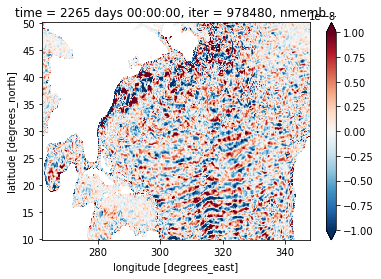

In [112]:
varpipp[0].isel(sig=16).plot(vmax=1e-8)

In [12]:
# e00 = (tmp00 * sigmaxb**-1).compute()
# e01 = (tmp01 * sigmaxb**-1).compute()
# e10 = (tmp10 * sigmayb**-1).compute()
# e11 = (tmp11 * sigmayb**-1).compute()
# e20 = (tmp20 * sigmab**-1).compute()
# e21 = (tmp21 * sigmab**-1).compute()

# dsave = e00.to_dataset(name='e00')
# dsave['e01'] = e01
# dsave['e10'] = e10
# dsave['e11'] = e11
# dsave['e20'] = e20
# dsave['e21'] = e21
# dsave.coords['YG'] = ('YG',dsz.YG.data)
# dsave.coords['XG'] = ('XG',dsz.XG.data)
# dsave.coords['sigp1'] = ('sigp1',dsz.sigp1)
# dsave.to_netcdf(op.join(ddir,'%4d/E-P_flux_%010d_%2d_gradP.nc' 
#                         % (year,943920,nremap)), mode='w')
# dsave.close()

e00 = dsep.e00
e10 = dsep.e10
e20 = dsep.e20
e01 = dsep.e01
e11 = dsep.e11
e21 = dsep.e21

### ${\bf u}C$ is a flux, so ${\bf u}u$ is also a flux. Hence, ${\bf u}(u\sigma)$ would also be a flux. $\zeta^2$ nor $\zeta \nabla m$ though are not fluxes.

In [15]:
# # e00_x = (grid.diff(tmp00*ds.dyG,'X') * ds.rA**-1 
# #          * sigmab**-1).compute()
# e00_x = ((grid.diff(tmp00_0*ds.dyG,'X') * ds.rA**-1
#           + grid.diff(tmp00_1,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1
#          ) * sigmab**-1).compute()
# # e00_x = (grid.diff(tmp00,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1
# #          * sigmab**-1).compute()
# e10_y = (grid.diff(tmp10*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
#          * sigmab**-1).compute()
# # e10_y = (grid.diff(tmp10,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
# #          * sigmab**-1).compute()
# e20_b = (grid.interp(grid.diff(tmp20,'Z',boundary='fill') 
#                      * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                      'Z',boundary='fill')
#          * sigmab**-1).compute()
# # e20b = grid.interp(grid.diff(tmp20,'Z',boundary='fill') 
# #                    * grid.diff(buoyb,'Z',boundary='fill')**-1
# #                    * sigmazb**-1,
# #                    'Z',boundary='fill').compute()
# e01_x = (grid.diff(tmp01*ds.dyG,'X') * ds.rA**-1 
#          * sigmab**-1).compute()
# # e01_x = (grid.diff(tmp01,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1 
# #          * sigmab**-1).compute()
# # e11_y = (grid.diff(tmp11*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
# #          * sigmab**-1).compute()
# e11_y = ((grid.diff(tmp11_0*ds.dxG,'Y',boundary='fill') * ds.rA**-1
#           + grid.diff(tmp11_1,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
#          ) * sigmab**-1).compute()
# # e11_y = (grid.diff(tmp11,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
# #          * sigmab**-1).compute()
# e21_b = (grid.interp(grid.diff(tmp21,'Z',boundary='fill') 
#                      * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                      'Z',boundary='fill') 
#          * sigmab**-1).compute()
# # e21b = grid.interp(grid.diff(tmp21,'Z',boundary='fill') 
# #                    * grid.diff(buoyb,'Z',boundary='fill')**-1 
# #                    * sigmazb**-1,
# #                    'Z',boundary='fill').compute()

# dsave = e00_x.to_dataset(name='e00x')
# dsave['e01x'] = e01_x
# dsave['e10y'] = e10_y
# dsave['e11y'] = e11_y
# dsave['e20b'] = e20_b
# dsave['e21b'] = e21_b
# dsave.coords['YG'] = ('YG',dsz.YG.data)
# dsave.coords['XG'] = ('XG',dsz.XG.data)
# dsave.coords['sigp1'] = ('sigp1',dsz.sigp1)
# dsave.to_netcdf(op.join(ddir,'%4d/divE-P_flux_%010d_%2d_gradP.nc' 
#                         % (year,943920,nremap)), mode='w')
# dsave.close()

e00_x = dsdiv.e00x
e10_y = dsdiv.e10y
e20_b = dsdiv.e20b
e01_x = dsdiv.e01x
e11_y = dsdiv.e11y
e21_b = dsdiv.e21b
# # print(e00_x, e11_y)

In [16]:
Eu = e00_x + e10_y + e20_b
Ev = e01_x + e11_y + e21_b
PVpx = sigmab**-1 * Ev
PVpy = -sigmab**-1 * Eu

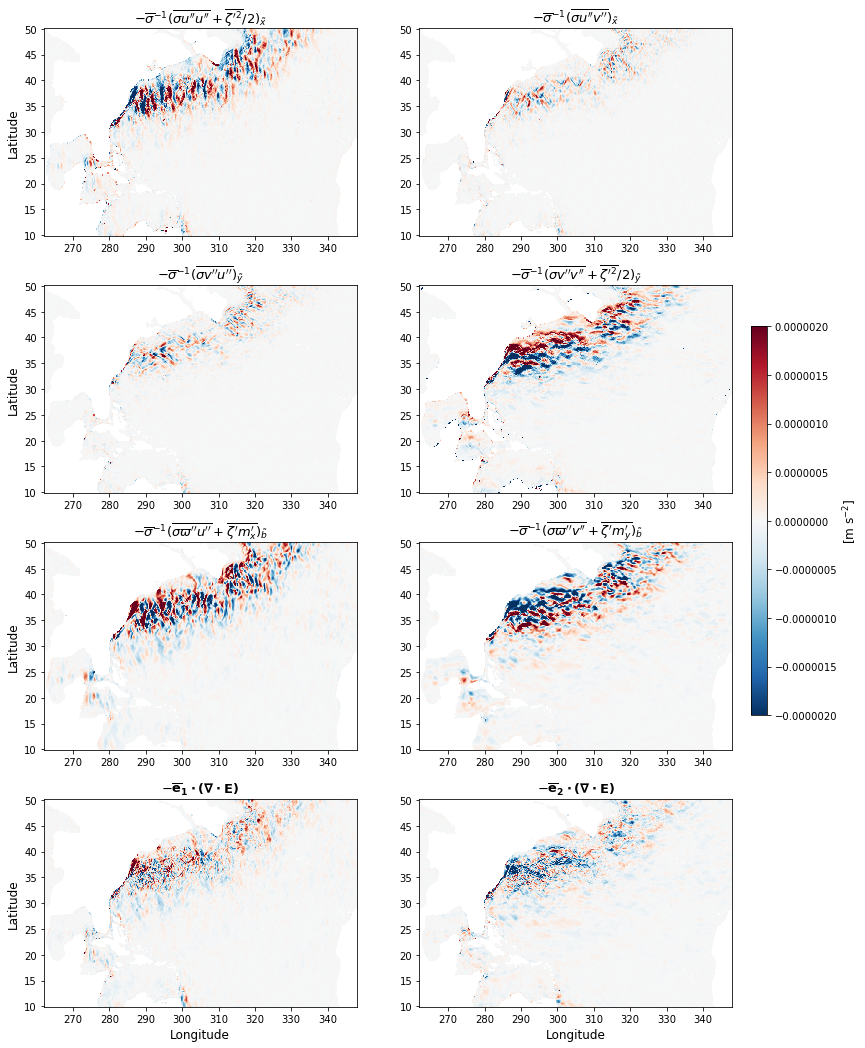

In [17]:
fig, axes = plt.subplots(figsize=(13,18), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC, -e00_x.isel(sig=16), 
                          vmax=2e-6, vmin=-2e-6, 
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(e10_y.XC, e10_y.YC, -e10_y.isel(sig=16), 
                     vmax=2e-6, vmin=-2e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(e01_x.XC, e01_x.YC, -e01_x.isel(sig=16), 
                     vmax=2e-6, vmin=-2e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(e11_y.XC, e11_y.YC, -e11_y.isel(sig=16), 
                     vmax=2e-6, vmin=-2e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(e20_b.XC, e20_b.YC, -e20_b.isel(sig=16), 
                     vmax=2e-6, vmin=-2e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(e21_b.XC, e21_b.YC, -e21_b.isel(sig=16), 
                     vmax=2e-6, vmin=-2e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(e00_x.XC, e00_x.YC, -Eu.isel(sig=16), 
                     vmax=2e-6, vmin=-2e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(e01_x.XC, e01_x.YC, -Ev.isel(sig=16), 
                     vmax=2e-6, vmin=-2e-6, 
                     cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                    fontsize=13)
axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                    fontsize=13)
axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                    fontsize=13)
axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                    fontsize=13)
axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=13)
axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=13)
axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=13)
axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=13)

axes[3,0].set_xlabel(r"Longitude", fontsize=12)
axes[3,1].set_xlabel(r"Longitude", fontsize=12)
axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)
axes[3,0].set_ylabel(r"Latitude", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.24)
cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/Div_E-P_flux_%4d-%010d.pdf' % (year,itime)))

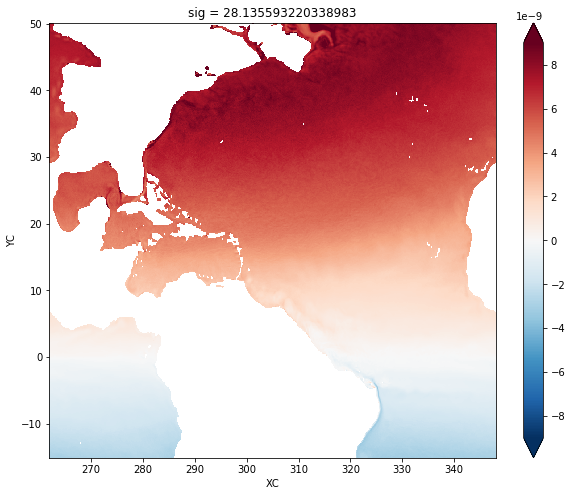

In [40]:
Pi.isel(sig=16).plot(figsize=(10,8), vmin=-9e-9, vmax=9e-9, 
                     cmap='RdBu_r', rasterized=True,
#                      norm=clr.SymLogNorm(1e-9)
                    )

In [102]:
divPVp = (grid.interp(grid.diff(Eu*grid.interp(ds.dyG,'X'),'X'),
                      'Y',boundary='fill')
          - grid.interp(grid.diff(Eu*grid.interp(ds.dxG,'Y',boundary='fill'),
                                  'Y',boundary='fill'),'X')
         ) * ds.rAz**-1 * sigmazb**-1
divPVp

<xarray.DataArray (YG: 783, XG: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(398, 248, 60), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float32 -15.041634 -14.9583 -14.874967 ... 50.041702 50.125034
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    rAz      (YG, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>

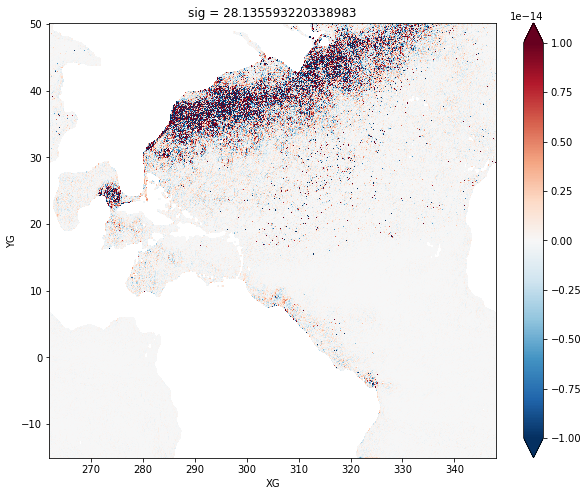

In [104]:
divPVp.isel(sig=16).plot(figsize=(10,8), vmin=-1e-14, vmax=1e-14, 
                         cmap='RdBu_r', rasterized=True,
#                      norm=clr.SymLogNorm(1e-9)
                        )

In [113]:
xx, yy = np.meshgrid(sigmab.sel(YC=slice(29,38),XC=slice(288,320)).XC, 
                     sigmab.sel(YC=slice(29,38),XC=slice(288,320)).YC)
Ny,Nx = xx.shape
dx = gsw.distance([xx[int(.5*Ny),int(.5*Nx)],xx[int(.5*Ny),int(.5*Nx+1)]],
                  [yy[:,int(.5*Nx)].mean(),yy[:,int(.5*Nx)].mean()])[0]
dy = gsw.distance([xx[int(.5*Ny)].mean(),xx[int(.5*Ny)].mean()],
                  [yy[int(.5*Ny),int(.5*Nx)],yy[int(.5*Ny+1),int(.5*Nx)]])[0]


array = np.ma.masked_invalid(Eu.isel(sig=16).sel(YC=slice(29,38),
                                                 XC=slice(288,320))
                            )
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]
Eu_inp = griddata((x1,y1), newarr.ravel(), (xx,yy), method='linear')
Eu_inp = xr.DataArray(Eu_inp, dims=['YC','XC'],
                      coords={'YC':np.arange(0,dy*Ny,dy),
                              'XC':np.arange(0,dx*Nx,dx)})

array = np.ma.masked_invalid(Ev.isel(sig=16).sel(YC=slice(29,38),
                                                 XC=slice(288,320))
                            )
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]
Ev_inp = griddata((x1,y1), newarr.ravel(), (xx,yy), method='linear')
Ev_inp = xr.DataArray(Ev_inp, dims=['YC','XC'],
                      coords={'YC':np.arange(0,dy*Ny,dy),
                              'XC':np.arange(0,dx*Nx,dx)})
Ev_inp

<xarray.DataArray (YC: 108, XC: 371)>
array([[-3.59212875e-08, -5.89864550e-08,  1.97694261e-08, ...,
        -6.75900277e-09,  8.56934384e-08,  6.24162656e-08],
       [-5.88925909e-08, -9.53701746e-08, -1.95793073e-08, ...,
         9.49444144e-08,  1.03189002e-07,  1.08864546e-07],
       [-1.27150144e-08, -8.04475768e-08, -1.88456295e-08, ...,
         1.43579436e-07,  1.25002937e-07,  1.33611609e-07],
       ...,
       [ 2.49258594e-06,  1.56303479e-06, -8.02246104e-07, ...,
         1.49048510e-07,  1.16528968e-07,  1.14686270e-07],
       [ 1.09378477e-06,  4.43541934e-07,  1.90349691e-06, ...,
         8.86116259e-08,  1.59155535e-07,  6.56573031e-08],
       [ 1.47351814e-06,  1.49073298e-06,  8.33028013e-07, ...,
         7.68490360e-08,  9.64135733e-08,  1.18467889e-07]])
Coordinates:
  * YC       (YC) float64 0.0 9.266e+03 1.853e+04 ... 9.822e+05 9.915e+05
  * XC       (XC) float64 0.0 7.984e+03 1.597e+04 ... 2.946e+06 2.954e+06

In [114]:
FEu = xrft.dft(Eu_inp, dim=['YC','XC'], 
               shift=False, detrend='linear', window=True)
FEv = xrft.dft(Ev_inp, dim=['YC','XC'], 
               shift=False, detrend='linear', window=True)
kx = 2*np.pi*FEu.freq_XC
ky = 2*np.pi*FEu.freq_YC
FdivE = 1j*(FEu*kx - FEv*ky)
FdivE

<xarray.DataArray (freq_YC: 108, freq_XC: 371)>
array([[ 0.00000000e+00+0.00000000e+00j,  1.20188586e-09-8.56567494e-10j,
        -1.88724305e-09-1.95772816e-10j, ...,
        -1.53496321e-09+7.70203556e-11j, -1.88724305e-09+1.95772816e-10j,
         1.20188586e-09+8.56567494e-10j],
       [ 7.70949898e-10-2.53510044e-09j, -3.72675067e-10-1.69567296e-09j,
         3.05222759e-10-4.23016153e-10j, ...,
         2.80474113e-09-2.99937662e-10j,  3.15959629e-09-2.63787896e-09j,
        -2.84430983e-09+1.16870492e-09j],
       [ 2.07610736e-09+5.08482039e-09j,  3.82947149e-09+9.22914249e-10j,
        -1.85274065e-09+2.57656194e-09j, ...,
        -4.41204489e-09+2.39047983e-09j, -2.33732472e-09+2.40778350e-09j,
        -4.19175595e-10+3.85898879e-10j],
       ...,
       [-7.27483733e-09+3.32014227e-09j,  2.04616158e-09+5.40818400e-09j,
         1.85210205e-09+2.55582309e-10j, ...,
        -6.14165134e-09-3.12740574e-09j,  4.10063446e-09+2.83514804e-09j,
        -5.64743224e-09-2.03439753e-09j],
       [ 2.07610736e-09-5.08482039e-09j, -4.19175595e-10-3.85898879e-10j,
        -2.33732472e-09-2.40778350e-09j, ...,
         5.12247495e-09+2.73289174e-09j, -1.85274065e-09-2.57656194e-09j,
         3.82947149e-09-9.22914249e-10j],
       [ 7.70949898e-10+2.53510044e-09j, -2.84430983e-09-1.16870492e-09j,
         3.15959629e-09+2.63787896e-09j, ...,
        -1.16748418e-09+2.59424636e-10j,  3.05222759e-10+4.23016153e-10j,
        -3.72675067e-10+1.69567296e-09j]])
Coordinates:
  * freq_YC          (freq_YC) float64 0.0 9.993e-07 ... -1.999e-06 -9.993e-07
  * freq_XC          (freq_XC) float64 0.0 3.376e-07 ... -6.752e-07 -3.376e-07
    freq_YC_spacing  float64 9.993e-07
    freq_XC_spacing  float64 3.376e-07

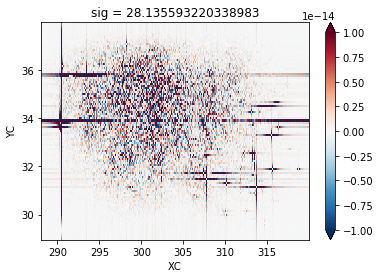

In [111]:
FFdivF = xr.DataArray(np.fft.ifft2(FdivE.data).real, dims=['YC','XC'],
                      coords={'YC':sigmab.sel(YC=slice(29,38),XC=slice(288,320)).YC,
                              'XC':sigmab.sel(YC=slice(29,38),XC=slice(288,320)).XC}
                     ) * sigmab.isel(sig=16)**-1
FFdivF.plot(vmax=1e-14)

In [125]:
# Fpsi = -FdivE * (kx**2 + ky**2)**-1
FdivPVp = xrft.dft(divPVp.drop_vars('rAz').isel(sig=16).sel(YG=slice(29,38),
                                                            XG=slice(288,320)
                                                           ).chunk({'YG':-1,'XG':-1}), 
                   dim=['YG','XG'], shift=False, window=True)
kx = 2*np.pi*FdivPVp.freq_XG
ky = 2*np.pi*FdivPVp.freq_YG
Fpsi = -FdivPVp * (kx**2 + ky**2)**-1
FFpsi = xr.DataArray(np.fft.ifft2(Fpsi.data).real, dims=['YG','XG'],
                     coords={'YG':sigmazb.sel(YG=slice(29,38),XG=slice(288,320)).YG,
                             'XG':sigmazb.sel(YG=slice(29,38),XG=slice(288,320)).XG}
                    )
FFpsi

<xarray.DataArray 'real-1371113c38f514b2be93c879e0a8c3bd' (YG: 108, XG: 372)>
dask.array<real, shape=(108, 372), dtype=float64, chunksize=(108, 372), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float32 29.041702 29.125034 29.208368 ... 37.875034 37.95837
  * XG       (XG) float32 288.03275 288.1188 288.20483 ... 319.8744 319.96045

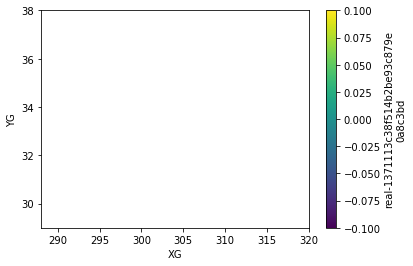

In [126]:
FFpsi.plot()

In [79]:
grid.diff(np.log(sigmab),'X') * ds.dxC**-1

<xarray.DataArray (YC: 783, XG: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(400, 249, 60), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    dyG      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(400, 250), meta=np.ndarray>

### Since we're taking $v_\tilde{x}$ and $u_\tilde{y}$ consist with the finite-volume discretization, it makes sense to take $v_{\tilde{x}\tilde{x}}$ for example in the same manner.

In [14]:
def filt(da, area=None, dim=['YC','XC'], nker=6, cutoff=4):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    return da_LS

In [15]:
# Pix = grid.diff(Pi*grid.interp(ds.dyG,'X'),'X') * ds.rAw**-1
# Piy = grid.diff(Pi*grid.interp(ds.dxG,'Y',boundary='fill'),
#                 'Y',boundary='fill') * ds.rAs**-1
# kappax = -PVpx * grid.interp(Pix**-1,'X')
# kappay = -PVpy * grid.interp(Piy**-1,'Y',boundary='fill')
vort_sm = filt(vort.chunk({'YG':-1,'XG':-1}), area=ds.rAz, dim=['YG','XG'])
zetaxb_sm = filt(zetaxb.chunk({'YC':-1,'XG':-1}), area=ds.rAw, dim=['YC','XG'])
zetayb_sm = filt(zetayb.chunk({'YG':-1,'XC':-1}), area=ds.rAs, dim=['YG','XC'])
sigmab_sm = filt(sigmab.chunk({'YC':-1,'XC':-1}), area=ds.rA, dim=['YC','XC'])

vortsm_x = grid.diff(vort_sm*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vortsm_y = grid.diff(vort_sm*grid.interp(ds.dxG,'X'),
                     'Y',boundary='fill') * ds.rAw**-1
vort_x = grid.diff(vort*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vort_y = grid.diff(vort*grid.interp(ds.dxG,'X'),
                   'Y',boundary='fill') * ds.rAw**-1
# vort_x = grid.diff(vort,'X') * ds.dxG**-1
# vort_y = grid.diff(vort,'Y',boundary='fill') * ds.dyG**-1
# v_x = grid.diff(vhat*ds.dyC,'X') * ds.rAz**-1
# u_y = grid.diff(uhat*ds.dxC,'Y',boundary='fill') * ds.rAz**-1
# v_xx = grid.diff(v_x*grid.interp(ds.dyC,'X'),'X') * ds.rAs**-1
# u_yx = grid.diff(u_y*grid.interp(ds.dyC,'X'),'X') * ds.rAs**-1
# vort_x = v_xx - u_yx
# v_xy = grid.diff(v_x*grid.interp(ds.dxC,'Y',boundary='fill'),
#                  'Y',boundary='fill') * ds.rAw**-1
# u_yy = grid.diff(u_y*grid.interp(ds.dxC,'Y',boundary='fill'),
#                  'Y',boundary='fill') * ds.rAw**-1
# vort_y = v_xy - u_yy

# zetab_x = grid.diff(zetaxb*ds.dyG,'X') * ds.rA**-1
# zetab_y = grid.diff(zetayb*ds.dxG,'Y',boundary='fill') * ds.rA**-1
zetabsm_x = grid.diff(zetaxb_sm,'X')*grid.interp(ds.dxC,'X')**-1
zetabsm_y = (grid.diff(zetayb_sm,'Y',boundary='fill')
             * grid.interp(ds.dyC,'Y',boundary='fill')**-1)
zetab_x = grid.diff(zetaxb,'X')*grid.interp(ds.dxC,'X')**-1
zetab_y = grid.diff(zetayb,'Y',boundary='fill')*grid.interp(ds.dyC,'Y',boundary='fill')**-1
# dzetab_x = grid.diff(dsz.dzetaFx.mean('nmemb')*ds.dyG,'X') * ds.rA**-1
# dzetab_y = grid.diff(dsz.dzetaFy.mean('nmemb')*ds.dxG,'Y',
#                      boundary='fill') * ds.rA**-1
# dzetab_x = grid.interp(grid.diff(dsz.dzetaF.mean('nmemb'),'X') * ds.dxC**-1,'X')
# dzetab_y = grid.interp(grid.diff(dsz.dzetaF.mean('nmemb'),
#                                  'Y', boundary='fill') * ds.dyC**-1,
#                        'Y',boundary='fill')

sigmabsm_x = grid.interp(grid.diff(zetabsm_x,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill')
sigmabsm_y = grid.interp(grid.diff(zetabsm_y,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill')
sigmab_x = grid.interp(grid.diff(zetab_x,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')
sigmab_y = grid.interp(grid.diff(zetab_y,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')
# sigmab_x = dzetab_x * -grid.diff(buoybp1,'Z',boundary='fill')**-1
# sigmab_y = dzetab_y * -grid.diff(buoybp1,'Z',boundary='fill')**-1
# sigb_x_sigb = grid.interp(grid.diff(np.log(sigmab),'X')*ds.dxC**-1,'X')
# sigb_y_sigb = grid.interp(grid.diff(np.log(sigmab),'Y',boundary='fill')*ds.dyC**-1,
#                           'Y',boundary='fill')

absvortsm = fC + grid.interp(grid.interp(vort_sm,'X'),'Y',boundary='fill')
Pism_xs = (grid.interp(vortsm_x,'Y',boundary='fill')
           - sigmab_x * sigmab_sm**-1 * absvortsm)
Pism_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
           + grid.interp(vortsm_y,'X')
          ) - sigmab_y * sigmab_sm**-1 * absvortsm
absvort = fC + grid.interp(grid.interp(vort,'X'),'Y',boundary='fill')
Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
         - sigmab_x * sigmab**-1 * absvort)
Pi_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
         + grid.interp(vort_y,'X')
        ) - sigmab_y * sigmab**-1 * absvort
# Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
#          - absvort * sigb_x_sigb)
# Pi_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
#          + grid.interp(vort_y,'X')
#         ) - absvort * sigb_y_sigb

Pism_x = Pism_xs * sigmab_sm**-1
Pism_y = Pism_ys * sigmab_sm**-1
Pi_x = Pi_xs * sigmab**-1
Pi_y = Pi_ys * sigmab**-1
# Pi_x = grid.diff(Pi,'X') * ds.dxC**-1
# Pi_y = grid.diff(Pi,'Y',boundary='fill') * ds.dyC**-1
# kappax = -Ev * Pi_xs**-1
# kappay = Eu * Pi_ys**-1
# print(kappax,kappay)
print(Pi_y,Pi_x)

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(398, 248, 58), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0 <xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(398, 248, 58), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0


In [ ]:
fig, axes = plt.subplots(figsize=(13,11), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC, PVpx.isel(sig=16), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC, PVpy.isel(sig=16), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XG, dsz.YC, -Pi_x.isel(sig=16), 
                           vmin=-1e-14, vmax=1e-14, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YG, -Pi_y.isel(sig=16), 
                           vmin=-1e-14, vmax=1e-14, cmap='coolwarm', rasterized=True)
# im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC, kappax.isel(sig=16), 
#                            vmax=9e3, vmin=-9e3, cmap='bwr', 
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)
# im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC, kappay.isel(sig=16), 
#                            vmax=9e3, vmin=-9e3, cmap='bwr',
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)

axes[0,0].set_title(r"$\hat{u''\Pi''}$ $(= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=15)
axes[0,1].set_title(r"$\hat{v''\Pi''}$ $(= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=15)
axes[1,0].set_title(r"$-\Pi^\#_\tilde{x}$", fontsize=15)
axes[1,1].set_title(r"$-\Pi^\#_\tilde{y}$", 
                    fontsize=15)
# axes[2,0].set_title(r"$\kappa^u (= -\hat{u''\Pi''}/\Pi^\#_\tilde{x})$", 
#                     fontsize=15)
# axes[2,1].set_title(r"$\kappa^v (= -\hat{v''\Pi''}/\Pi^\#_\tilde{y})$", 
#                     fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
# axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86) 
cbax0 = fig.add_axes([0.88, 0.6, 0.018, 0.2])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m s$^{-4}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[m$^{-1}$ s$^{-3}$]", fontsize=12)
# cbax4 = fig.add_axes([0.88, 0.15, 0.018, 0.17])
# cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
# cbar4.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/PV_flux_1963-Dec-26_80_tracer_gradP.pdf'))

In [16]:
that = dsmn.tdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
shat = dsmn.sdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
that_sm = filt(that.chunk({'YC':-1,'XC':-1}), area=ds.rA, dim=['YC','XC'])
shat_sm = filt(shat.chunk({'YC':-1,'XC':-1}), area=ds.rA, dim=['YC','XC'])
# that_x = grid.diff(that*grid.interp(ds.dyG,'X'),'X') * ds.rAw**-1
# that_y = grid.diff(that*grid.interp(ds.dxG,'Y',boundary='fill'),
#                    'Y',boundary='fill') * ds.rAs**-1
# shat_x = grid.diff(shat*grid.interp(ds.dyG,'X'),'X') * ds.rAw**-1
# shat_y = grid.diff(shat*grid.interp(ds.dxG,'Y',boundary='fill'),
#                    'Y',boundary='fill') * ds.rAs**-1
thatsm_x = grid.diff(that_sm,'X') * ds.dxC**-1
thatsm_y = grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1
shatsm_x = grid.diff(shat_sm,'X') * ds.dxC**-1
shatsm_y = grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1
that_x = grid.diff(that,'X') * ds.dxC**-1
that_y = grid.diff(that,'Y',boundary='fill') * ds.dyC**-1
shat_x = grid.diff(shat,'X') * ds.dxC**-1
shat_y = grid.diff(shat,'Y',boundary='fill') * ds.dyC**-1

tpp = dsmn.tdz * dsz.dzetaF**-1 - that
spp = dsmn.sdz * dsz.dzetaF**-1 - shat
upptpphat = (upp*grid.interp(tpp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
uppspphat = (upp*grid.interp(spp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1

# print(that_x, that_y, shat_x, shat_y, upptpphat, vpptpphat)

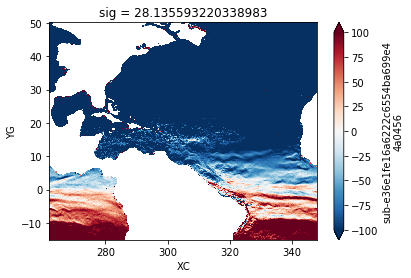

In [51]:
grid.diff(shat * grid.interp(ds.dxG,'Y',boundary='fill'),
          'Y',boundary='fill'
         ).isel(sig=16).plot(vmax=1e2, vmin=-1e2, cmap='RdBu_r')

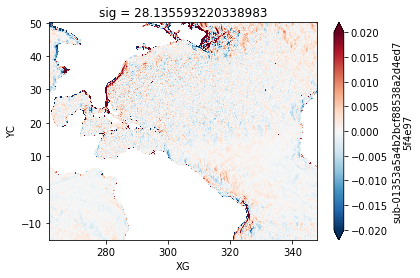

In [47]:
grid.diff(shat,'X').isel(sig=16).plot(vmax=.02, vmin=-.02, cmap='RdBu_r')

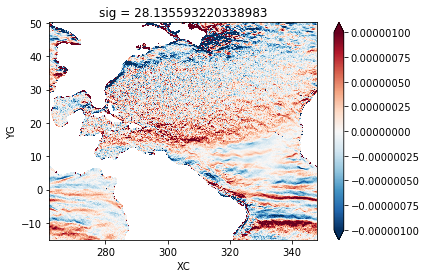

In [56]:
shat_y.isel(sig=16).plot(vmax=1e-6, vmin=-1e-6, cmap='RdBu_r')

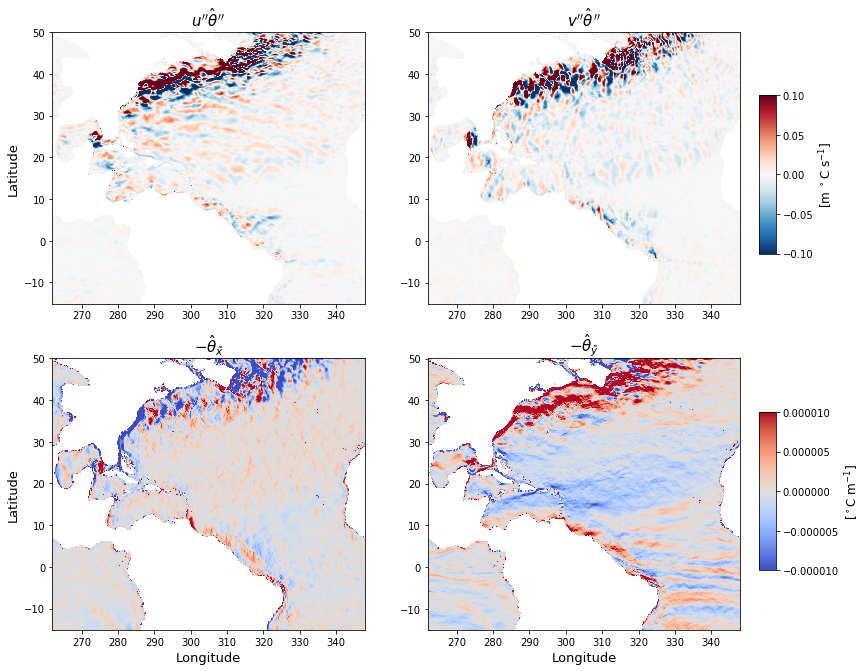

In [23]:
fig, axes = plt.subplots(figsize=(13,11), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XG, dsz.YC, upptpphat.isel(sig=16), 
                           vmin=-1e-1, vmax=1e-1, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YG, vpptpphat.isel(sig=16), 
                           vmin=-1e-1, vmax=1e-1, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XG, dsz.YC, -that_x.isel(sig=16), 
                           vmin=-1e-5, vmax=1e-5, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YG, -that_y.isel(sig=16), 
                           vmin=-1e-5, vmax=1e-5, cmap='coolwarm', rasterized=True)
# im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC, kappax.isel(sig=16), 
#                            vmax=9e3, vmin=-9e3, cmap='bwr', 
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)
# im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC, kappay.isel(sig=16), 
#                            vmax=9e3, vmin=-9e3, cmap='bwr',
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)

axes[0,0].set_title(r"$\hat{u''\theta''}$", fontsize=15)
axes[0,1].set_title(r"$\hat{v''\theta''}$", fontsize=15)
axes[1,0].set_title(r"$-\hat{\theta}_\tilde{x}$", fontsize=15)
axes[1,1].set_title(r"$-\hat{\theta}_\tilde{y}$", fontsize=15)
# axes[2,0].set_title(r"$\kappa^u (= -\hat{u''\Pi''}/\Pi^\#_\tilde{x})$", 
#                     fontsize=15)
# axes[2,1].set_title(r"$\kappa^v (= -\hat{v''\Pi''}/\Pi^\#_\tilde{y})$", 
#                     fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
# axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86) 
cbax0 = fig.add_axes([0.88, 0.6, 0.018, 0.2])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m $^\circ$C s$^{-1}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[$^\circ$C m$^{-1}$]", fontsize=12)
# cbax4 = fig.add_axes([0.88, 0.15, 0.018, 0.17])
# cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
# cbar4.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/THETA_flux_1963-Dec-26_80.pdf'))

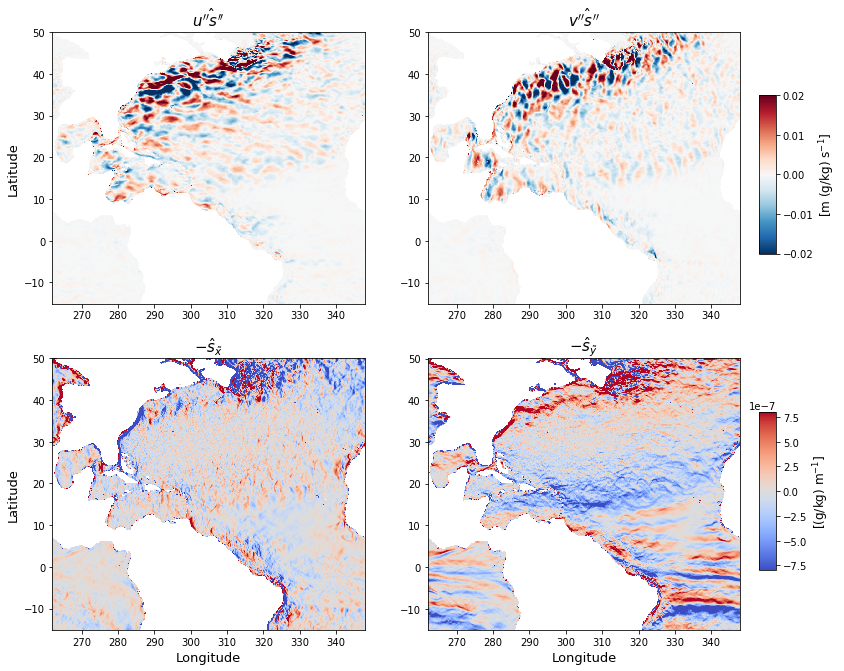

In [24]:
fig, axes = plt.subplots(figsize=(13,11), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XG, dsz.YC, uppspphat.isel(sig=16), 
                           vmin=-2e-2, vmax=2e-2, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YG, vppspphat.isel(sig=16), 
                           vmin=-2e-2, vmax=2e-2, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XG, dsz.YC, -shat_x.isel(sig=16), 
                           vmin=-8e-7, vmax=8e-7, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YG, -shat_y.isel(sig=16), 
                           vmin=-8e-7, vmax=8e-7, cmap='coolwarm', rasterized=True)
# im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC, kappax.isel(sig=16), 
#                            vmax=9e3, vmin=-9e3, cmap='bwr', 
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)
# im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC, kappay.isel(sig=16), 
#                            vmax=9e3, vmin=-9e3, cmap='bwr',
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)

axes[0,0].set_title(r"$\hat{u''s''}$", fontsize=15)
axes[0,1].set_title(r"$\hat{v''s''}$", fontsize=15)
axes[1,0].set_title(r"$-\hat{s}_\tilde{x}$", fontsize=15)
axes[1,1].set_title(r"$-\hat{s}_\tilde{y}$", fontsize=15)
# axes[2,0].set_title(r"$\kappa^u (= -\hat{u''\Pi''}/\Pi^\#_\tilde{x})$", 
#                     fontsize=15)
# axes[2,1].set_title(r"$\kappa^v (= -\hat{v''\Pi''}/\Pi^\#_\tilde{y})$", 
#                     fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
# axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86) 
cbax0 = fig.add_axes([0.88, 0.6, 0.018, 0.2])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m (g/kg) s$^{-1}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[(g/kg) m$^{-1}$]", fontsize=12)
# cbax4 = fig.add_axes([0.88, 0.15, 0.018, 0.17])
# cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
# cbar4.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/SALT_flux_1963-Dec-26_80.pdf'))

In [17]:
ut = grid.interp(upptpphat.isel(sig=slice(14,30)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vt = grid.interp(vpptpphat.isel(sig=slice(14,30)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
us = grid.interp(uppspphat.isel(sig=slice(14,30)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vs = grid.interp(vppspphat.isel(sig=slice(14,30)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
uPV = PVpx.isel(sig=slice(14,30)).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vPV = PVpy.isel(sig=slice(14,30)).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()

tx = grid.interp(thatsm_x.isel(sig=slice(14,30)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
ty = grid.interp(thatsm_y.isel(sig=slice(14,30)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sx = grid.interp(shatsm_x.isel(sig=slice(14,30)),
                 'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sy = grid.interp(shatsm_y.isel(sig=slice(14,30)),
                 'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVx = Pism_x.isel(sig=slice(14,30)).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVy = Pism_y.isel(sig=slice(14,30)).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()

In [20]:
ut_norm = (ut * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1)
vt_norm = (vt * np.nanmedian(np.sqrt(ut**2 + vt**2),
                             axis=(0,1))**-1)
us_norm = (us * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
vs_norm = (vs * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
uPV_norm = (uPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)
vPV_norm = (vPV * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)

tx_norm = (tx * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1)
ty_norm = (ty * np.nanmedian(np.sqrt(ut**2 + vt**2), 
                             axis=(0,1))**-1)
sx_norm = (sx * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
sy_norm = (sy * np.nanmedian(np.sqrt(us**2 + vs**2),
                             axis=(0,1))**-1)
PVx_norm = (PVx * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)
PVy_norm = (PVy * np.nanmedian(np.sqrt(uPV**2 + vPV**2),
                               axis=(0,1))**-1)

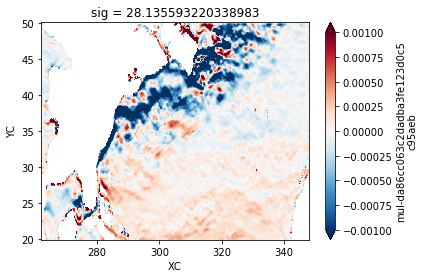

In [89]:
ty_norm.isel(sig=2).plot(vmax=1e-3)

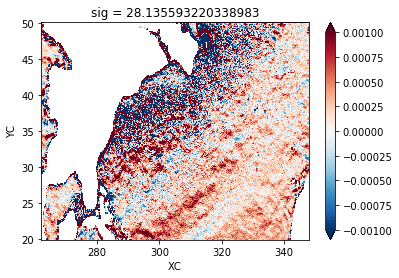

In [90]:
PVy_norm.isel(sig=2).plot(vmax=1e-3)

In [26]:
dxT = grid.interp(ds.dxG,'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyT = grid.interp(ds.dyG,'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyU = ds.dyG.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dxV = ds.dxG.sel(YG=slice(yNstart+5,yend+2*12**-1)).load()
print(dxT.shape, dyT.shape, dyU.shape, dxV.shape)

(362, 1000) (362, 1000) (362, 1000) (362, 1000)


In [ ]:
# ut_flat = np.ma.masked_invalid(ut).compressed()
# vt_flat = np.ma.masked_invalid(vt).compressed()
# us_flat = np.ma.masked_invalid(us).compressed()
# vs_flat = np.ma.masked_invalid(vs).compressed()
# upi_flat = np.ma.masked_invalid(upi).compressed()
# vpi_flat = np.ma.masked_invalid(vpi).compressed()
# tx_flat = np.ma.masked_invalid(tx).compressed()
# ty_flat = np.ma.masked_invalid(ty).compressed()
# sx_flat = np.ma.masked_invalid(sx).compressed()
# sy_flat = np.ma.masked_invalid(sy).compressed()
# PVx_flat = np.ma.masked_invalid(PVx).compressed()
# PVy_flat = np.ma.masked_invalid(PVy).compressed()

# F = xr.DataArray(np.array([[ut_flat,   vt_flat],
#                            [us_flat,   vs_flat],
#                            [upi_flat, vpi_flat]]
#                          ), dims=['dimension','variable','ndata']
#                 ).chunk({'ndata':1})
# G = xr.DataArray(np.array([[tx_flat,   ty_flat],
#                            [sx_flat,   sy_flat],
#                            [PVx_flat, PVy_flat]]
#                          ), dims=['dimension','variable','ndata']
#                 ).chunk({'ndata':1})
# K = xr.apply_ufunc(np.dot,
#                     xr.apply_ufunc(np.dot,
#                       xr.apply_ufunc(np.linalg.inv,
#                         xr.apply_ufunc(np.dot,xr.apply_ufunc(np.transpose, G,
#                                         kwargs={'axes':['dimension','variable']}, 
#                                         dask='parallelized', output_dtypes=['float',]
#                                                             ),G,
#                                         dask='parallelized', output_dtypes=['float',]
#                                       ), dask='parallelized', output_dtypes=['float',]
#                                     ),
#                         xr.apply_ufunc(np.transpose, G, 
#                                        kwargs={'axes':['dimension','variable']}, 
#                                        dask='parallelized', output_dtypes=['float',]
#                                       ), dask='parallelized', output_dtypes=['float',]
#                                   ),
#                    F, dask='parallelized', output_dtypes=['float',])

K = xr.DataArray(np.ones((len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),
                          len(dsz.XC),len(dsz.sig.isel(sig=slice(14,30))),2,2))*np.nan,
                 dims=['YC','XC','sig','col','row'],
                 coords={'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data,
                         'XC':dsz.XC.data, 'sig':dsz.sig.isel(sig=slice(14,30)).data}
                )
print(K.shape)

for j in range(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)))):
    if j % 10 == 0:
        print(j)
    for i in range(len(dsz.XC)):
        if i < len(dsz.XC)-1:
            k = i+1
        else:
            k = 0
        for l in range(len(dsz.sig.isel(sig=slice(14,30)))):

            rowF  = np.array([ 8, 8, 
                               9, 9,
                              10,10])
            colF  = np.array([0, 2, 
                              0, 2, 
                              0, 2])
            dataF = np.array([ ut_norm.isel(YC=j,XC=i,sig=l),  vt_norm.isel(YC=j,XC=i,sig=l),
                               us_norm.isel(YC=j,XC=i,sig=l),  vs_norm.isel(YC=j,XC=i,sig=l),
                              uPV_norm.isel(YC=j,XC=i,sig=l), vPV_norm.isel(YC=j,XC=i,sig=l)]
                            )
            F = spar.csr_matrix((dataF, (rowF, colF)), shape=(11,4)).toarray()
#             F = np.array([[ ut_norm.isel(YC=j,XC=i,sig=k),  vt_norm.isel(YC=j,XC=i,sig=k)],
#                           [ us_norm.isel(YC=j,XC=i,sig=k),  vs_norm.isel(YC=j,XC=i,sig=k)],
#                           [uPV_norm.isel(YC=j,XC=i,sig=k), vPV_norm.isel(YC=j,XC=i,sig=k)]]
#                         )
        
            rowG  = np.array([0, 0, 0, 
                              1, 1, 1,
                              2, 2, 2, 
                              3, 3, 3,
                              4, 4 ,4, 
                              5, 5, 5,
                              6, 6, 6, 
                              7, 7, 7,
                              8, 8, 9, 9,10,10])
            colG  = np.array([0, 1, 2, 
                              3, 4, 5,
                              6, 7, 8, 
                              9,10,11,
                              0, 1, 2, 
                              3, 4, 5,
                              6, 7, 8, 
                              9,10,11,
                              1, 4, 1, 4, 1, 4])
            dataG = np.array([(dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,
                              -dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                          + dyU.isel(YC=j,XG=i)**-1
                                                         ),
                              (dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,

                              (dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,
                              -dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                          + dyU.isel(YC=j,XG=i)**-1
                                                         ),
                              (dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,

                              (dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1,
                              -dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                        + dxV.isel(YG=j,XC=i)**-1
                                                       ),
                              (dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1,

                              (dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1,
                              -dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                        + dxV.isel(YG=j,XC=i)**-1
                                                       ),
                              (dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1,
    ##############################
                              (dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,
                              -dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                          + dyU.isel(YC=j,XG=i)**-1
                                                         ),
                              (dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,

                              (dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,
                              -dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                          + dyU.isel(YC=j,XG=i)**-1
                                                         ),
                              (dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1,

                              (dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1,
                              -dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                        + dxV.isel(YG=j,XC=i)**-1
                                                       ),
                              (dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1,

                              (dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1,
                              -dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                        + dxV.isel(YG=j,XC=i)**-1
                                                       ),
                              (dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1,
    ##############################    
                               -tx_norm.isel(YC=j,XC=i,sig=l),  -ty_norm.isel(YC=j,XC=i,sig=l),
                               -sx_norm.isel(YC=j,XC=i,sig=l),  -sy_norm.isel(YC=j,XC=i,sig=l),
                              -PVx_norm.isel(YC=j,XC=i,sig=l), -PVy_norm.isel(YC=j,XC=i,sig=l)]
                            )
            G = spar.csr_matrix((dataG, (rowG, colG)), shape=(11,12)).toarray()
#             G = -np.array([[ tx_norm.isel(YC=j,XC=i,sig=k),  ty_norm.isel(YC=j,XC=i,sig=k)],
#                            [ sx_norm.isel(YC=j,XC=i,sig=k),  sy_norm.isel(YC=j,XC=i,sig=k)],
#                            [PVx_norm.isel(YC=j,XC=i,sig=k), PVy_norm.isel(YC=j,XC=i,sig=k)]]
#                          )
            if ~(np.isnan(F).any() or np.isnan(G).any()):
    #             try:
    #             tmp = np.linalg.inv(np.transpose(G).dot(G)).dot(np.transpose(G)).dot(F)
    #             K.isel(YC=j,XC=i)[0,0] = tmp[1,0]
    #             K.isel(YC=j,XC=i)[1,0] = tmp[4,0]
    #             K.isel(YC=j,XC=i)[0,1] = tmp[1,2]
    #             K.isel(YC=j,XC=i)[1,1] = tmp[4,2]
#                 GT = np.transpose(G)
#                 K.isel(YC=j,XC=i,sig=k)[:] = np.linalg.inv(GT.dot(G)).dot(GT).dot(F)
                tmp = np.linalg.pinv(G).dot(F)
                K.isel(YC=j,XC=i,sig=l)[0,0] = tmp[1,0]
                K.isel(YC=j,XC=i,sig=l)[1,0] = tmp[4,0]
                K.isel(YC=j,XC=i,sig=l)[0,1] = tmp[1,2]
                K.isel(YC=j,XC=i,sig=l)[1,1] = tmp[4,2]
    #             except:
    #                 pass

itime = 943920
K.to_dataset(name='K').to_netcdf(op.join(ddir,
                                         '%4d/Diff-tensor_isig14-30_%010d_50_Ksmoothed.nc' 
                                         % (year,itime)))

(361, 1000, 16, 2, 2)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [ ]:
K[:,:,0,0].isel(sig=2).plot(vmax=4e4)

In [ ]:
K[:,:,1,0].isel(sig=2).plot(vmax=4e4)

In [ ]:
K[:,:,0,1].isel(sig=2).plot(vmax=4e4)

In [ ]:
K[:,:,1,1].isel(sig=2).plot(vmax=4e4)

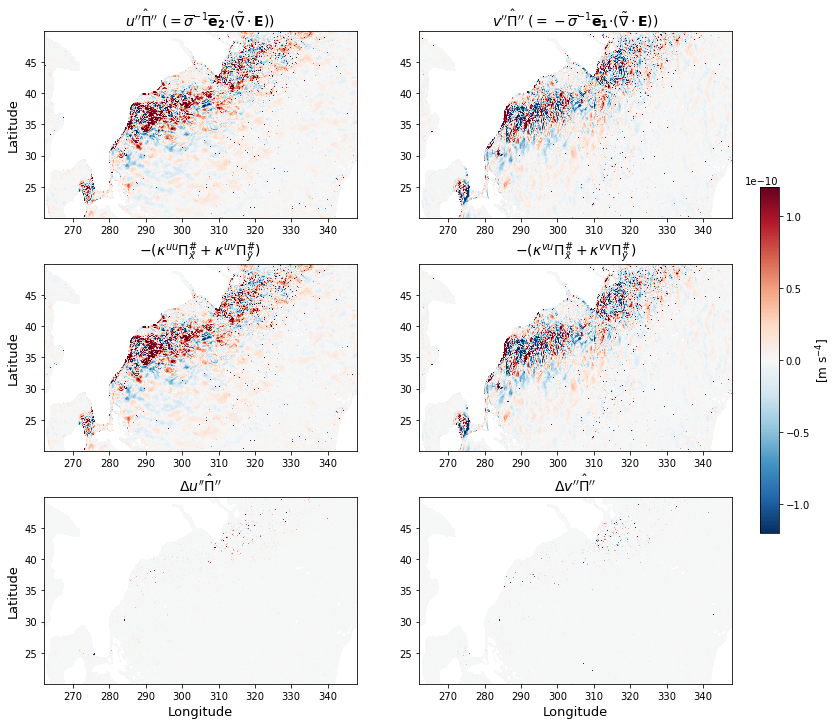

In [77]:
fig, axes = plt.subplots(figsize=(13,12), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           uPV.sel(YC=slice(yNstart+5,yend)), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           vPV.sel(YC=slice(yNstart+5,yend)), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -(K[:,:,0,0]*PVx.sel(YC=slice(yNstart+5,yend))
                             + K[:,:,1,0]*PVy.sel(YC=slice(yNstart+5,yend))), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           -(K[:,:,0,1]*PVx.sel(YC=slice(yNstart+5,yend))
                             + K[:,:,1,1]*PVy.sel(YC=slice(yNstart+5,yend))), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           uPV.sel(YC=slice(yNstart+5,yend))
                           + (K[:,:,0,0]*PVx.sel(YC=slice(yNstart+5,yend))
                              + K[:,:,1,0]*PVy.sel(YC=slice(yNstart+5,yend))), 
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r', 
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)
im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart+5,yend)), 
                           vPV.sel(YC=slice(yNstart+5,yend)) 
                           + (K[:,:,0,1]*PVx.sel(YC=slice(yNstart+5,yend))
                              + K[:,:,1,1]*PVy.sel(YC=slice(yNstart+5,yend))),
                           vmin=-1.2e-10, vmax=1.2e-10, cmap='RdBu_r',
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)

axes[0,0].set_title(r"$\hat{u''\Pi''}$ $(= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[0,1].set_title(r"$\hat{v''\Pi''}$ $(= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\Pi^\#_\tilde{x} + \kappa^{uv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\Pi^\#_\tilde{x} + \kappa^{vv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[2,0].set_title(r"$\Delta \hat{u''\Pi''}$", 
                    fontsize=14)
axes[2,1].set_title(r"$\Delta \hat{v''\Pi''}$", 
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.25) 
cbax0 = fig.add_axes([0.89, 0.3, 0.02, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m s$^{-4}$]", fontsize=12)
# cbax2 = fig.add_axes([0.88, 0.2, 0.018, 0.2])
# cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
# cbar2.set_label(r"[m s$^{-4}$]", fontsize=12)
# cbax4 = fig.add_axes([0.88, 0.15, 0.018, 0.17])
# cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
# cbar4.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/PV_param_1963-Dec-26_50_smoothed.pdf'))

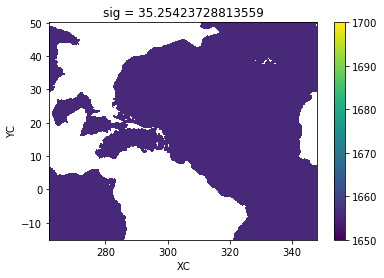

In [80]:
(-zetab).isel(sig=30).plot(vmin=1650, vmax=1700)

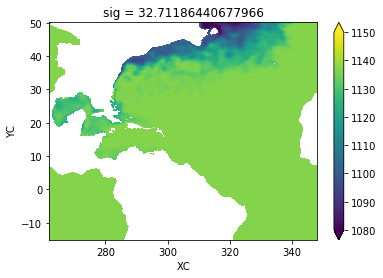

In [76]:
(-zetab).isel(sig=25).plot(vmin=1080, vmax=1150)

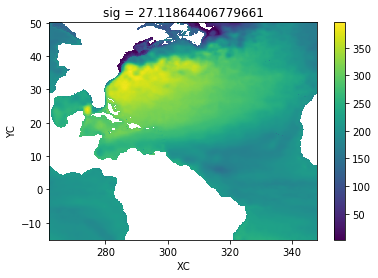

In [70]:
(-zetab).isel(sig=14).plot()

# $$\int \nabla\cdot{\bf E} d\zeta = \int \nabla\cdot{\bf E}\sigma d\tilde{b}$$

In [25]:
with ProgressBar():
    e00xH = (grid.diff(dsig.sigmax[-1]*dsep.e00[-1]*dsraw.dyG,'X') * dsraw.rA**-1 
             * grid.diff(buoybp1,'Z',boundary='fill')).sum('sig', skipna=True).compute()
    e10yH = (grid.diff(dsig.sigmay[-1]*dsep.e10[-1]*dsraw.dxG,
                      'Y',boundary='fill') * dsraw.rA**-1 
             * grid.diff(buoybp1,'Z',boundary='fill')).sum('sig', skipna=True).compute()
    e20bH = (grid.diff(dsig.sigma[-1]*dsep.e20[-1],'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1
             * grid.diff(buoyb,'Z',boundary='fill')).sum('sigp1', skipna=True).compute()

    e01xH = (grid.diff(dsig.sigmax[-1]*dsep.e01[-1]*dsraw.dyG,'X') * dsraw.rA**-1 
             * grid.diff(buoybp1,'Z',boundary='fill')).sum('sig', skipna=True).compute()
    e11yH = (grid.diff(dsig.sigmay[-1]*dsep.e11[-1]*dsraw.dxG,
                      'Y',boundary='fill') * dsraw.rA**-1 
             * grid.diff(buoybp1,'Z',boundary='fill')).sum('sig', skipna=True).compute()
    e21bH = (grid.diff(dsig.sigma[-1]*dsep.e21[-1],'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1 
             * grid.diff(buoyb,'Z',boundary='fill')).sum('sigp1', skipna=True).compute()

[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[#####################################   ] | 94% Completed |  7.2s

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)


[########################################] | 100% Completed |  7.8s
[                                        ] | 0% Completed |  0.0s

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[#####################################   ] | 94% Completed |  4.1s

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)


[########################################] | 100% Completed |  4.7s


/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


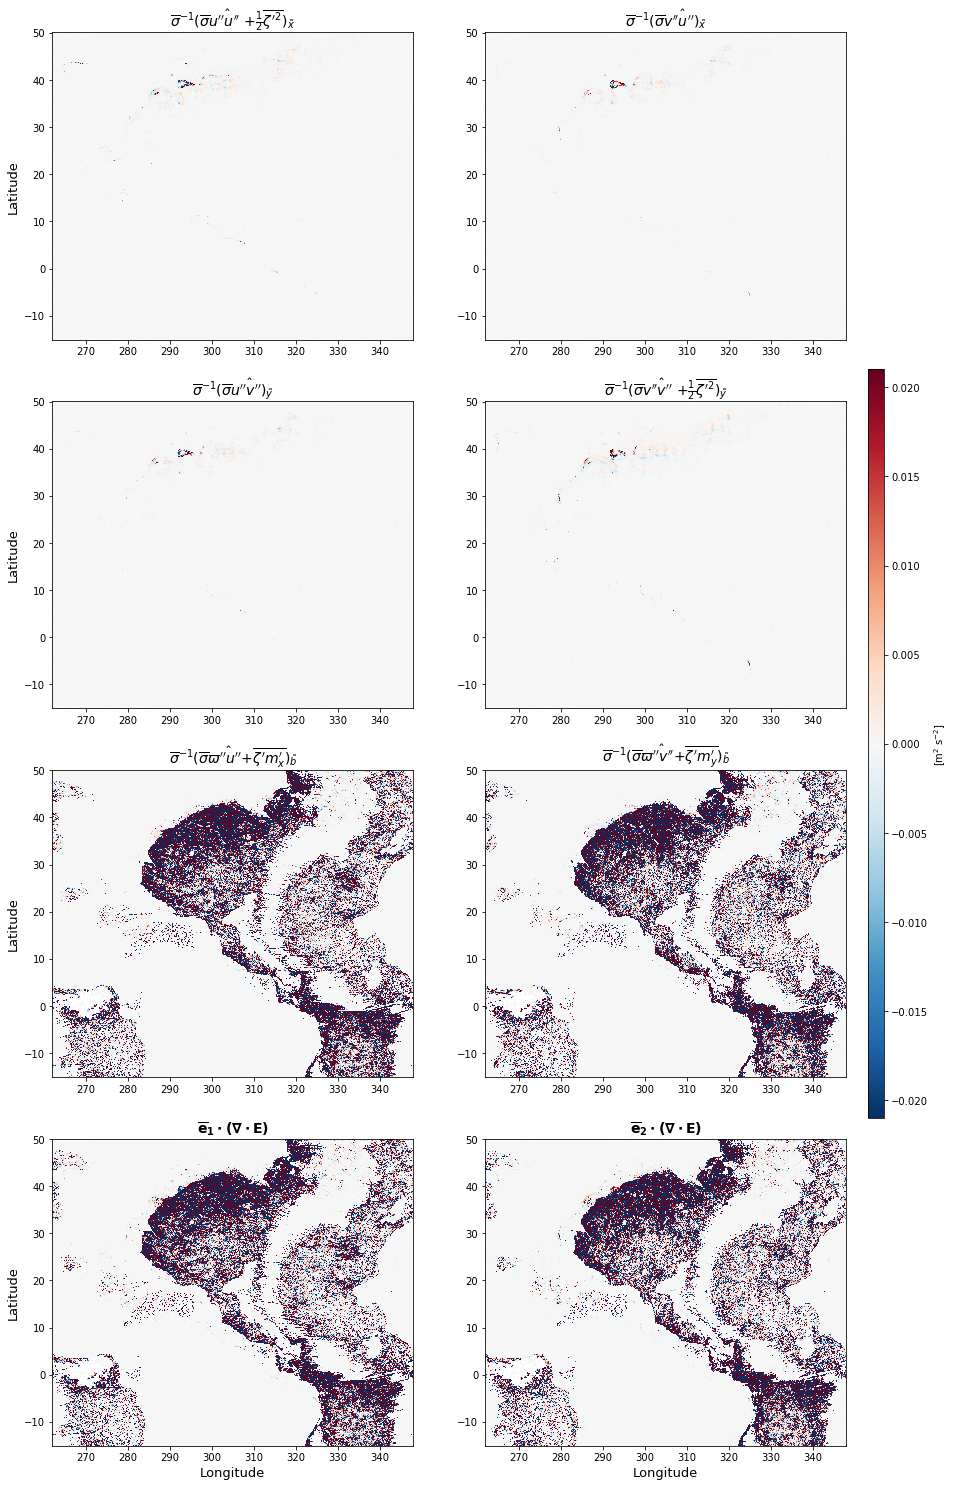

In [29]:
fig, axes = plt.subplots(figsize=(15,26), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00x.XC, e00x.YC, e00xH, vmax=2.1e-2, vmin=-2.1e-2,
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(e10y.XC, e10y.YC, e10yH, vmax=2.1e-2, vmin=-2.1e-2,
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(e01x.XC, e01x.YC, e01xH, vmax=2.1e-2, vmin=-2.1e-2,
                     cmap='RdBu_r', rasterized=True)
# (zdz*dzetaF**-1).mean('nmemb')[:,:,25].plot(ax=axes[0,0], vmin=-6e2, vmax=-3e2, 
#                                             cmap='Blues_r', rasterized=True)
axes[1,1].pcolormesh(e11y.XC, e11y.YC, e11yH, vmax=2.1e-2, vmin=-2.1e-2,
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(e20b.XC, e20b.YC, e20bH, vmax=2.1e-2, vmin=-2.1e-2,
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(e21b.XC, e21b.YC, e21bH, vmax=2.1e-2, vmin=-2.1e-2,
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(e00x.XC, e00x.YC, (e00xH+e10yH+e20bH), vmax=2.1e-2, vmin=-2.1e-2,
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(e01x.XC, e01x.YC, (e01xH+e11yH+e21bH), vmax=2.1e-2, vmin=-2.1e-2,
                     cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''u''}$ "
                    + r"$+ \frac{1}{2}\overline{\zeta'^2})_\tilde{x}$", 
                    fontsize=14)
axes[1,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''v''})_\tilde{y}$", fontsize=14)
axes[0,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''u''})_\tilde{x}$", fontsize=14)
# axes[0,0].set_title(r"$\overline{\zeta}$", fontsize=15)
axes[1,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''v''}$ "
                    + r"$+ \frac{1}{2}\overline{\zeta'^2})_\tilde{y}$", 
                    fontsize=14)
axes[2,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{\varpi''u''}$"
                    + r"$+ \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=14)
axes[2,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{\varpi''v''}$"
                    + r"$+ \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=14)
axes[3,0].set_title(r"$\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
axes[3,1].set_title(r"$\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

axes[3,0].set_xlabel(r"Longitude", fontsize=13)
axes[3,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)
axes[3,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbaxes = fig.add_axes([0.88, 0.3, 0.015, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m$^2$ s$^{-2}$]")

# plt.savefig(op.join(savedir,'Figures/Div_E-P_flux_1963-Dec-26.pdf'))